In [4]:
import numpy as np
import pandas as pd
from sklearn.linear_model import LinearRegression, LassoCV,LogisticRegression
from sklearn.metrics import r2_score
from scipy.stats import norm
from sklearn.cluster import KMeans
import random
from statsmodels.regression.linear_model import OLS
import statsmodels.api as sm
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from sklearn.metrics import roc_auc_score

from scipy.stats import bernoulli

from scipy.special import expit

from matplotlib.ticker import MaxNLocator

# suppress all warnings
import warnings
warnings.filterwarnings("ignore")

# Default parameters

In [8]:
# number of items
n = 20

# number of features
d = 5

# number of observations for each item
obs = 10

# number of clusters
z = 2

# number of trials
T = 100

# noise
sigma = 1

# prob
p, q = 2/3,1/6

# Model with Benchmarks

In [9]:
def fit_classification_simulation(Ru,Rl,method="bfgs"):
    auc_alg_t, auc_b1_t, auc_b2_t, auc_lasso_t, auc_clus_t,auc_true_t =  np.zeros(T), np.zeros(T),np.zeros(T), np.zeros(T), np.zeros(T),np.zeros(T)
    
    flag = False
    for t in range(T):
        while not flag:
            # generate data
            data = np.random.rand(n*obs,d)
            data_test = np.random.rand(int(n*obs/2),d)

            # generate clusters and betas
            feature_dict = {}
            clus_dict = {} # might not be used depending on the feature dict

            for i in range(d):
                # whether this feature should be estimated at the department level or not
                feature_dict[i] = np.random.choice(['dept', 'clus', 'sku'], p = [p, q, 1-p-q])
            #print(feature_dict)



            for i in range(z):
                clus_items = random.sample(items,int(n/z))
                clus_dict[i] = clus_items
                items = items - set(clus_items)

            # generate Beta
            beta_dict = {}
            num_cols = 0
            for i in range(d):
                if feature_dict[i] == 'dept':
                    beta_dict[i] = (np.random.random_sample() - 0.5) * 10
                    num_cols += 1
                elif feature_dict[i] == 'clus':
                    beta_dict[i] = (np.random.random_sample(size = z) - 0.5) * 10
                    num_cols += z
                else:
                    beta_dict[i] = (np.random.random_sample(size = n) - 0.5) * 10
                    num_cols += n

            X_true = np.zeros((n*obs, num_cols))
            X_test = np.zeros((int(n*obs/2), num_cols))

            beta = np.zeros(num_cols)
            count = 0
            for i in range(d):
                if feature_dict[i] == 'dept':
                    beta[count] = beta_dict[i]
                    X_true[:,count] = data[:,i]
                    X_test[:,count] = data_test[:,i]

                    count += 1

                elif feature_dict[i] == 'clus':
                    for j in range(z):
                        clus_items = clus_dict[j]
                        for sku in clus_items:
                            X_true[sku*obs:(sku+1)*obs, count] = data[sku*obs:(sku+1)*obs, i]
                            X_test[int(sku*obs/2):int((sku+1)*obs/2), count] = data_test[int(sku*obs/2):int((sku+1)*obs/2), i]

                        beta[count] = beta_dict[i][j]
                        count += 1
                else:
                    for j in range(n):
                        X_true[j*obs:(j+1)*obs, count] = data[j*obs:(j+1)*obs, i]
                        X_test[int(j*obs/2):int((j+1)*obs/2), count] = data_test[int(j*obs/2):int((j+1)*obs/2), i]
                        beta[count] = beta_dict[i][j]
                        count += 1
            mu = np.dot(X_true, beta)
            mu_test = np.dot(X_test, beta)
            y = bernoulli.rvs(size=len(mu),p=expit(mu)) #generate y from a bernoulli distribution with p = logit(X*beta)
            y_test = bernoulli.rvs(size=len(mu_test),p=expit(mu_test))
            
            #we are going to test if some features only have labels 1 or 0 and repeat 
            #the data generation until we have balanced generated data
            c= 0
            for i in range(n):
                if np.mean(y[i*obs:(i+1)*obs])*(1-np.mean(y[i*obs:(i+1)*obs]))==0:
                    c +=1
            if c==0:
                break
        #Thoeretical Perfect DAC to perform sanity checks
        model_true = sm.Logit(y, X_true).fit(method=method,maxiter=100)
        y_pred = model_true.predict(X_test)
        auc_true_t[t] = roc_auc_score(y_test, np.array(y_pred))
        
        #DECENTRALIZED
        
        y_pred = []
        logit_models = {}
        for i in range(n):

            logit_models[i] = sm.Logit(y[i*obs:(i+1)*obs],data[i*obs:(i+1)*obs,:]).fit(method=method,maxiter=100)
            y_pred += list(logit_models[i].predict(data_test[int(i*obs/2):int((i+1)*obs/2),:]))

        auc_b1_t[t] = roc_auc_score(y_test,np.array(y_pred))
        
        
        #DAC
        
        aggre_level = []
        clus_columns = []
        all_coeff = np.zeros((n,d))
        all_coeff[0,:] = logit_models[0].params
        n_cols_alg = 0

        for j in range(d):

            # a n-1 vector recording if two betas have the same mean
            test_j = np.zeros(n-1)

            for i in range(1,n):
               #print(i,j)
                all_coeff[i,j] = logit_models[i].params[j]

                z_stat = ( np.abs(logit_models[0].params[j] - logit_models[i].params[j]) / 
                          np.sqrt(np.square(logit_models[0].bse[j]) + np.square(logit_models[i].bse[j])) )
                p_value = 1 - norm.cdf(z_stat)
                if p_value >= 0.05:  #P-value ->0.05
                    test_j[i-1] = 1

            if np.sum(test_j) >= Ru*(n-1):
                aggre_level.append('dept')
                n_cols_alg += 1

            elif np.sum(test_j) <= Rl*(n-1):
                aggre_level.append('sku')
                n_cols_alg += n

            else:
                aggre_level.append('clus')
                clus_columns.append(j)
                n_cols_alg += z

        if len(clus_columns) > 0:
            X_clus = all_coeff[:, clus_columns]
            kmeans = KMeans(n_clusters=z, random_state=0).fit(X_clus)

        X_alg = np.zeros((n*obs, n_cols_alg))
        X_test = np.zeros((int(n*obs/2), n_cols_alg))

        count = 0
        for i in range(d):
            if aggre_level[i] == 'dept':
                X_alg[:,count] = data[:,i]
                X_test[:,count] = data_test[:,i]
                count += 1

            elif aggre_level[i] == 'clus':
                for j in range(z):
                    clus_items = list(np.where(kmeans.labels_ == j)[0])
                    for sku in clus_items:
                        X_alg[sku*obs:(sku+1)*obs, count] = data[sku*obs:(sku+1)*obs, i]
                        X_test[int(sku*obs/2):int((sku+1)*obs/2), count] = data_test[int(sku*obs/2):int((sku+1)*obs/2), i]


                    count += 1
            else:
                for j in range(n):
                    X_alg[j*obs:(j+1)*obs, count] = data[j*obs:(j+1)*obs, i]
                    X_test[int(j*obs/2):int((j+1)*obs/2), count] = data_test[int(j*obs/2):int((j+1)*obs/2), i]
                    count += 1
                    
                    
        model_0 = sm.Logit(y,X_alg).fit(method=method,maxiter=100)
        auc_alg_t[t] = roc_auc_score(y_test,model_0.predict(X_test))
        
        
        # CENTRALIZED
        
        model_0 = sm.Logit(y,data).fit(method=method,maxiter=100)
        auc_b2_t[t] = roc_auc_score(y_test,model_0.predict(data_test))
        

        # CLUSTER 
        
        X_clus = np.zeros((n, d))
        count = 0
        y_pred = np.zeros(int(n*obs/2))
        for i in range(n):
            X_clus[count, :] = np.mean(data[i*obs:(i+1)*obs,:], axis = 0)
            count += 1
        
        kmeans = KMeans(n_clusters=z, random_state=0).fit(X_clus)
        for i in range(z):
            clus_items = list(np.where(kmeans.labels_ == i)[0])
            base_rows = np.array(list(range(obs)))
            base_rows_test = np.array(list(range(int(obs/2))))
            rows = []
            test_rows = []
            for j in clus_items:
                rows += list(range( j*obs, (j+1)*obs ))
                test_rows += list(range( j*int(obs/2), (j+1)*int(obs/2) ))
            
            model_i = sm.Logit(y[np.ix_(rows)], data[np.ix_(rows)]).fit(method=method,maxiter=100)
            y_pred[np.ix_(test_rows)] = model_i.predict(data_test[np.ix_(test_rows)])

        auc_clus_t[t] = roc_auc_score(y_test,np.array(y_pred))
        
        
    return(np.mean(auc_alg_t),np.mean(auc_b1_t),np.mean(auc_b2_t),np.mean(auc_clus_t),np.mean(auc_true_t))
        

# Varying features

### Varying number of items

In [ ]:
list_n = [i for i in range(10,35,5)]

T=100 
obs = 50

auc_alg, auc_b1, auc_b2, auc_clus = [], [], [], []
for n in list_n:
    result_1, result_2, result_3, result_4,result_5 = fit_classification_simulation(0.9,0.6)
    auc_alg.append(result_1)
    auc_b1.append(result_2)
    auc_b2.append(result_3)
    auc_clus.append(result_4)
    print("items:",n)

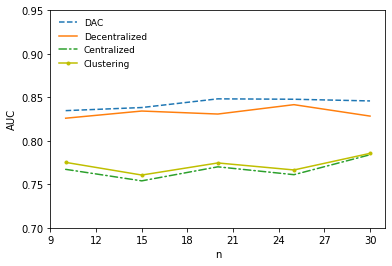

In [12]:
fig, ax = plt.subplots()

plt.plot(list_n, auc_alg,"--",label = 'DAC')
plt.plot(list_n, auc_b1,'',label = 'Decentralized')
plt.plot(list_n, auc_b2,linestyle=(0, (5, 2, 1, 2)), dash_capstyle='round',label = 'Centralized')
plt.plot(list_n, auc_clus,'y-o',markersize=3,label = 'Clustering')




plt.legend(loc='upper left',frameon=False,prop={'size': 9})
plt.xlabel('n')
plt.ylabel('AUC')
plt.ylim(0.7,0.95)
ax.xaxis.set_major_locator(MaxNLocator(integer=True))
plt.show()

### Varying number of features

In [ ]:
list_d = [i for i in range(5,16,1)]

n = 20

T=100 
obs = 50

auc_alg, auc_b1, auc_b2, auc_clus = [], [], [], []
for d in list_d:
    result_1, result_2, result_3, result_4,result_5 = fit_classification_simulation(0.9,0.6)
    auc_alg.append(result_1)
    auc_b1.append(result_2)
    auc_b2.append(result_3)
    auc_clus.append(result_4)
    print("items:",n)

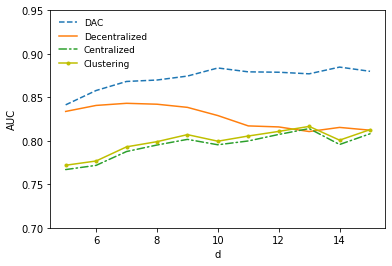

In [14]:
fig, ax = plt.subplots()

plt.plot(list_d, auc_alg,"--",label = 'DAC')
plt.plot(list_d, auc_b1,'',label = 'Decentralized')
plt.plot(list_d, auc_b2,linestyle=(0, (5, 2, 1, 2)), dash_capstyle='round',label = 'Centralized')
plt.plot(list_d, auc_clus,'y-o',markersize=3,label = 'Clustering')


plt.legend(loc='upper left',frameon=False,prop={'size': 9})
plt.xlabel('d')
plt.ylabel('AUC')
plt.ylim(0.7,0.95)
ax.xaxis.set_major_locator(MaxNLocator(integer=True))
plt.show()

### Varying number of observations

In [ ]:
list_m = [i for i in range(40,110,10)]

n = 20
d = 5
T= 100 

auc_alg, auc_b1, auc_b2, auc_clus = [], [], [], []
for obs in list_m:
    result_1, result_2, result_3, result_4,result_5 = fit_classification_simulation(0.9,0.6,"bfgs")
    auc_alg.append(result_1)
    auc_b1.append(result_2)
    auc_b2.append(result_3)
    auc_clus.append(result_4)
    print("obs:",obs)

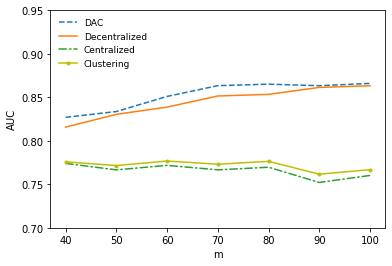

In [16]:
fig, ax = plt.subplots()

plt.plot(list_m, auc_alg,"--",label = 'DAC')
plt.plot(list_m, auc_b1,'',label = 'Decentralized')
plt.plot(list_m, auc_b2,linestyle=(0, (5, 2, 1, 2)), dash_capstyle='round',label = 'Centralized')
plt.plot(list_m, auc_clus,'y-o',markersize=3,label = 'Clustering')




plt.legend(loc='upper left',frameon=False,prop={'size': 9})
plt.xlabel('m')
plt.ylabel('AUC')
plt.ylim(0.7,0.95)
#ax.xaxis.set_major_locator(MaxNLocator(integer=True))
plt.show()